<a href="https://colab.research.google.com/github/xxxnmxhj00/Pythorch/blob/main/%5Btorch_3%5DCNN_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망

## 일반적인 신경망 모델

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), # ToTensor()로 변환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])# -1 ~ 1사이의 값으로 normalized
     # transform.Normalize((mean_1, mean_2, mean_3),(std_1, std_2, std_3))
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 36602725.82it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
for (X_train, y_train) in trainloader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


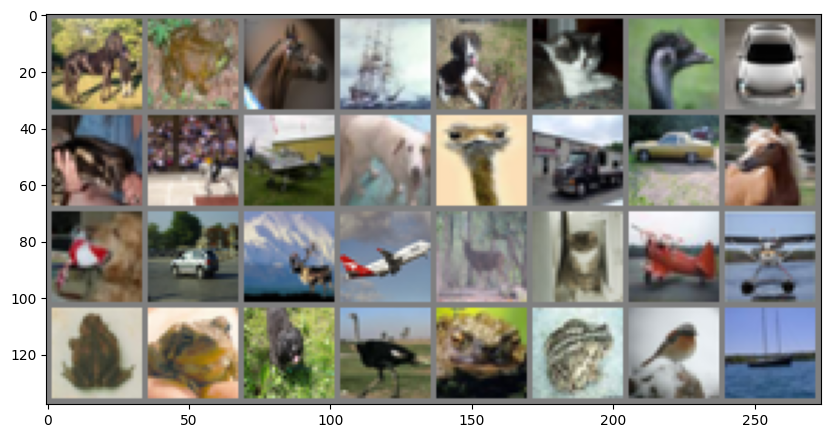

torch.Size([32, 3, 32, 32])


In [ ]:
def imshow(img):
    img = .5 * img + .5
    plt.figure(figsize=(10,100))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.show()

images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images,nrow=8))
print(images.size()) # 배치 및 이미지 크기 확인

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3,
                               padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3,
                               padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(-1, 8 * 8 * 16) # 텐서를 (?, 8 * 8 * 16)의 크기로 변경
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = F.log_softmax(x)
        return x

In [ ]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
         MaxPool2d-2            [-1, 8, 16, 16]               0
            Conv2d-3           [-1, 16, 16, 16]           1,168
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Linear-5                   [-1, 64]          65,600
            Linear-6                   [-1, 32]           2,080
            Linear-7                   [-1, 10]             330
Total params: 69,402
Trainable params: 69,402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 0.26
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [ ]:
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트
n = len(trainloader)
for epoch in tqdm(range(10)):  # 10번 학습을 진행한다.
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터
        optimizer.zero_grad()
        outputs = model(inputs) # 예측값 산출
        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화
        # print statistics
        running_loss += loss.item()
    loss_.append(running_loss / n)
    print(f'{epoch + 1} loss: {running_loss / len(trainloader):.3f}')

  0%|          | 0/10 [00:00<?, ?it/s]

[1] loss: 1.571
[2] loss: 1.254
[3] loss: 1.112
[4] loss: 1.027
[5] loss: 0.970
[6] loss: 0.922
[7] loss: 0.887
[8] loss: 0.855
[9] loss: 0.828
[10] loss: 0.800


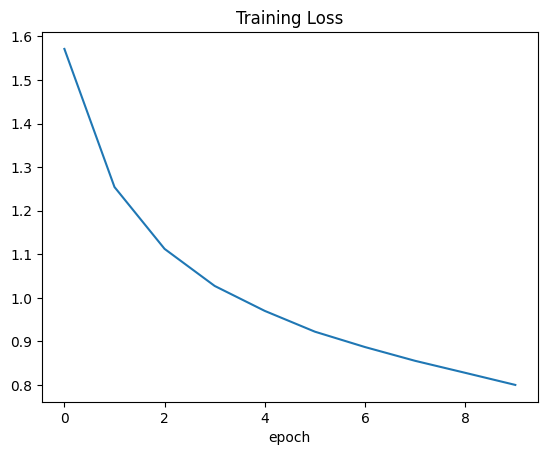

In [ ]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    # torch.no_grad()의 주된 목적은 autograd를 끔으로써 메모리 사용량을 줄이고 연산 속도를 높힌다.
    model.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images) # outputs은 크기가 (배치 크기)32인 벡터 형태로 나온다.
        _, predicted = torch.max(outputs, dim = 1)
        # torch.max는 최댓값과 최댓값의 위치를 산출해주는데 여기서 우리는
        # 최댓값은 필요가 없으므로 받지 않아도 된다.
        total += labels.size(0) # 개수 누적(총 개수)
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)
print('Test accuracy: %.2f %%' % (100 * correct / total))

Test accuracy: 65.39 %


## AlexNet

- AlexNet은 인공지능의 Classification 대회인 ILSVRC에서 2012년에 당시 오차율 16.4%로 다른 모델들을 압도하고 우승한 모델
- 지금 이 수치를 보자면 그렇게 좋은 정확도가 아니지만, 저 당시에는 굉장한 정확도
- AlexNet은 총 8개의 층으로 구성
> 첫 5개 층은 Convolution, 그 뒤 3개 층은 Fully-Connected 층
 - 1~2층은 Max Pooling 층입니다. 이를 통해 데이터의 중요한 요소들만 요약하여 추출
 - 3~5층은 서로 직접 연결되어 중간다리 역할
 - 5층 뒤에는 Max Pooling 층이 뒤따르는데, 이곳의 출력은 Fully Connected 층 두 개로 구성
 - 1~5층에서 학습된 데이터들은 Fully Connected 층에서 분류
 - 최종적으로는 1000 class label이 있는 Softmax 분류기로 분류

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # -1 ~ 1사이의 값으로 normalized

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 12776325.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


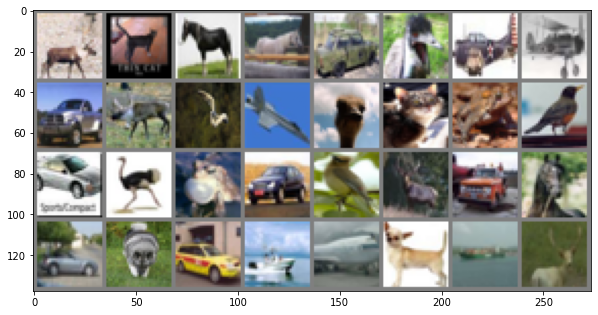

torch.Size([32, 3, 32, 32])


In [ ]:
# def imshow(img):
#     img = .5*img + .5
#     plt.figure(figsize=(10,100))
#     plt.imshow(img.permute(1,2,0).numpy())
#     plt.show()

# images, labels = iter(trainloader).next()
# imshow(torchvision.utils.make_grid(images,nrow=8))
# print(images.size()) # 배치 및 이미지 크기 확인

In [ ]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [ ]:
# Conv→ReLU→MaxPool→ Conv→ReLU→MaxPool→Conv→ReLU→ Conv→ReLU→Conv→ReLU→MaxPool→FC1→ReLU→FC2→ReLU→FC3
'''
AlexNet은 ImageNet데이터를 위해 만들어짐
ImageNet데이터는 1000개의 클래스로 분류되어 있는 256x256 또는 224x224 크기를 갖는 이미지.
따라서 크기가 32x32인 해당 이미지는 제대로 동작 안할 수 있음.
따라서 실제 AlexNet과 층은 동일하지만 필터와 stride는 이미지 크기에 맞게 조정 되었다.
https://m.blog.naver.com/laonple/221218707503
'''
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
                        nn.Conv2d(3, 64, 3), nn.ReLU(),
                        # nn.Conv2d(입력채널, 출력채널(필터수), 필터크기)
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(64, 192, 3, padding=1), nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(192, 384, 3, padding=1), nn.ReLU(),
                        nn.Conv2d(384, 256, 3, padding=1), nn.ReLU(),
                        nn.Conv2d(256, 256, 1), nn.ReLU(),
                        nn.MaxPool2d(2, 2)
                        )

        self.classifier = nn.Sequential(
                        nn.Dropout(0.5),
                        nn.Linear(256*3*3, 1024), nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(1024, 512), nn.ReLU(),
                        nn.Linear(512, 10)
                        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256*3*3) # 텐서를 (?, 256*3*3)의 크기로 변경
        x = self.classifier(x)
        return x

alexnet = AlexNet().to(device) # 모델 선언

In [ ]:
print(alexnet)
PATH = '/content/cifar_alexnet.pth' # 모델 저장 경로

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2304, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Lin

In [ ]:
from torchsummary import summary

summary(alexnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
              ReLU-2           [-1, 64, 30, 30]               0
         MaxPool2d-3           [-1, 64, 15, 15]               0
            Conv2d-4          [-1, 192, 15, 15]         110,784
              ReLU-5          [-1, 192, 15, 15]               0
         MaxPool2d-6            [-1, 192, 7, 7]               0
            Conv2d-7            [-1, 384, 7, 7]         663,936
              ReLU-8            [-1, 384, 7, 7]               0
            Conv2d-9            [-1, 256, 7, 7]         884,992
             ReLU-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          65,792
             ReLU-12            [-1, 256, 7, 7]               0
        MaxPool2d-13            [-1, 256, 3, 3]               0
          Dropout-14                 [-

In [ ]:
criterion = nn.CrossEntropyLoss()
# CrossEntropyLoss는 softmax 계산까지 포함되어 있으므로 모델의 마지막 output node에 별도의 활성화 함수를 사용하지 않아도 된다.
optimizer = optim.Adam(alexnet.parameters(), lr=1e-3)

In [ ]:
from tqdm.notebook import tqdm
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트
n = len(trainloader) # 배치 개수
for epoch in tqdm(range(10)):  # 1번 수행 후 문제 없이 실행 완료 되면 gpu로 변경해서 10번 학습을 진행한다.
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터
        optimizer.zero_grad()
        outputs = alexnet(inputs) # 예측값 산출
        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화
        running_loss += loss.item()
    loss_.append(running_loss / n)
    print('[%d] loss: %.3f' %(epoch + 1, running_loss / n))

  0%|          | 0/10 [00:00<?, ?it/s]

[1] loss: 1.596
[2] loss: 1.187
[3] loss: 1.005
[4] loss: 0.894
[5] loss: 0.810
[6] loss: 0.745
[7] loss: 0.686
[8] loss: 0.641
[9] loss: 0.606
[10] loss: 0.572


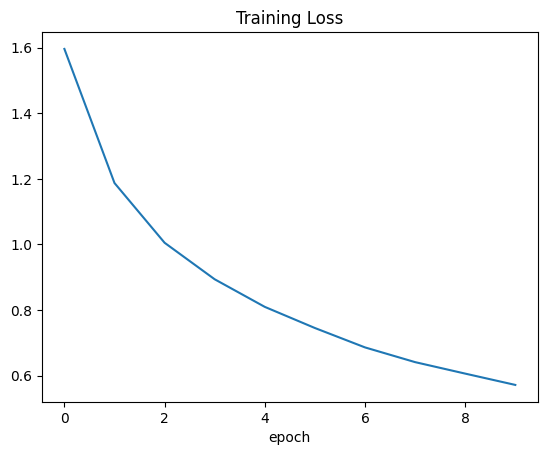

In [ ]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

### 모델 저장

In [ ]:
torch.save(alexnet.state_dict(), PATH) # 모델 저장

### model load

In [ ]:
# 모델 불러오기는 엄밀히 말하자면 모델의 파라메타를 불러오는 것이다.
# 따라서 모델의 뼈대를 먼저 선언하고
# 모델의 파라메타를 불러와 pretrained model을 만든다.

alexnet1 = AlexNet().to(device) # 모델의 뼈대를 먼저 선언
alexnet1.load_state_dict(torch.load(PATH)) # 모델 파라메타 불러오기

<All keys matched successfully>

### model Accuracy

In [ ]:
# 평가 데이터를 이용해 정확도를 구해보자.
# output은 미니배치의 결과가 산출되기 때문에 for문을 통해서 test 전체의 예측값을 구한다.

correct = 0
total = 0
with torch.no_grad():
    alexnet1.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet1(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0) # 개수 누적(총 개수)
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)

print('Test accuracy: %.2f %%' % (100 * correct / total))

Test accuracy: 75.69 %


## ReNet
- ResNet은 ILSVRC 2015 우승   
- [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)
- 합성곱 신경망에서 중요한 개념으로 자리 잡은 ResidualBlock을 제안한 모델
- 일반적으로 deep model일 수록 성능이 좋다.
- 하지만 모델이 깊어지는 경우 __기울기 소실과 폭발__ 문제가 발생한다.    
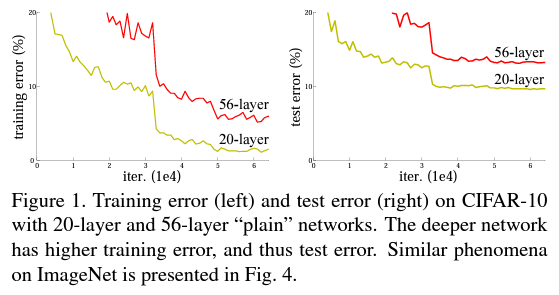
```
기울기 소실과 폭발: 기울기를 구하기 위해 가중치에 해당하는 손실 함수의 미분을 오차역전파법으로 구하는데,    
이 과정에서 활성화 함수의 편미분을 구하고 그 값을 곱한다.    
이는 layer가 뒷단으로 갈수록 활성화함수의 미분값이 점점 작아지거나 커지는 현상이 일어나는데,   
작은 미분값이 0에 가까워 지는 현상을 기울기 소실,    
큰 미분값이 여러번 곱해져 값이 커지는 현상을 기울기 폭발이라 한다.
```

- 이러한 문제를 해결하기 위해 스킵 커넥션(Skip Connection) 기술을 사용한다. 스킵 커넥션은 여러 레이어를 건너 뛰어 이전 정보를 더하는 것을 의미하며, 이 과정을 묶은 블록을 ResidualBlock이라 한다. ResidualBlock은 위치나 구조에 따라 성능이 달라 질 수 있지만 기본적으로 합성곱층 2, 3 칸을 뛰어 넘는 방식을 사용.
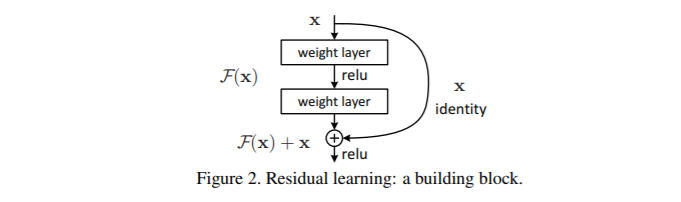

- ResNet는 기본적으로 7x7 필터와 3x3 맥스 풀링을 사용하지만 우리는 데이터 셋의 크기가 작기 때문에 적절한 합성곱 필터를 사용하고 풀링을 하지 않음.    
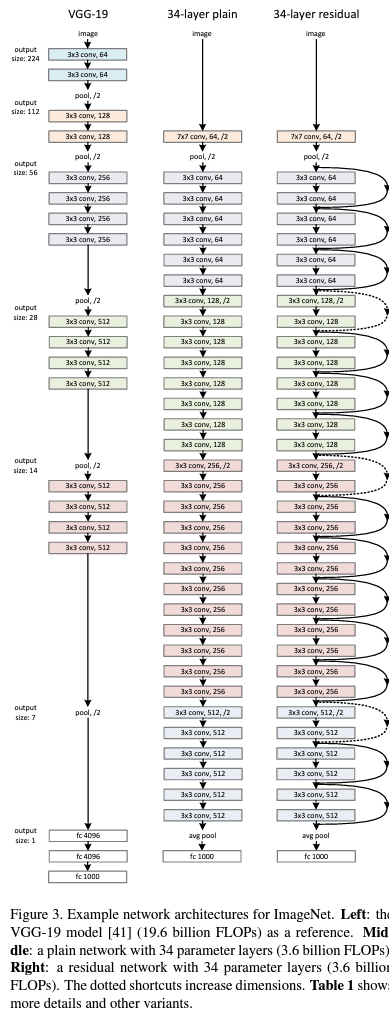

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 42799824.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [ ]:
print(device)

cuda:0


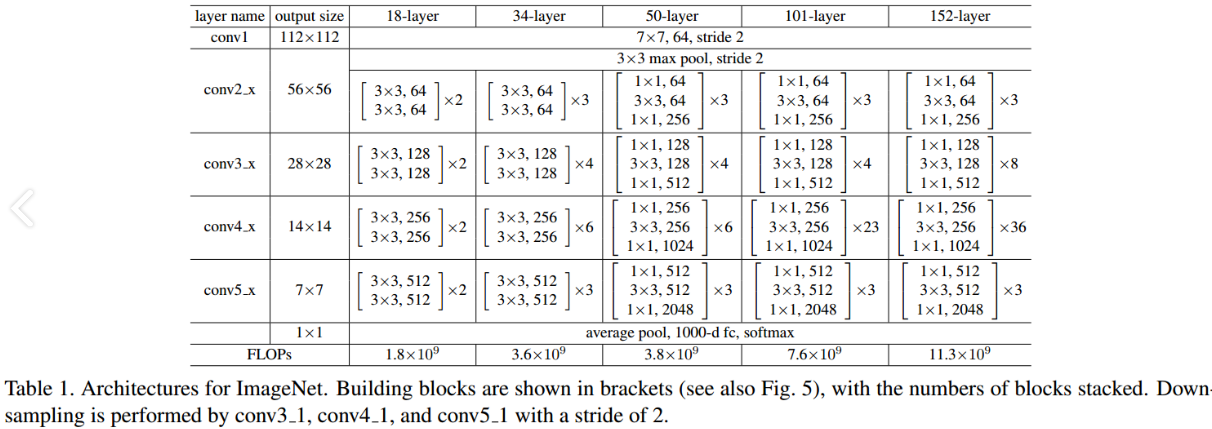

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv_block = nn.Sequential(
            # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3,
                      stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels), # 배치 정규화: 각 배치의 평균과 분산을 이용해 데이터를 정규화하는 방법
            nn.ReLU(),
            # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels))

        # stride가 1이 아니라면, Identity mapping이 아닌 경우
        '''ResNet는 ResidualBlock을 하나 거칠때 마다 이미지 사이즈가 줄어들고,
           채널 수는 늘어나는 구조. 따라서 처음 들어오는 x값과 블록을 거친 out값은 크기가 같아야 한다.
           따라서 차이가 나는 경우 출력값의 크기와 입력값의 크기를 동일하게 하기 위해 별도의 컨볼루션
           연산을 진행하여 크기를 맞춰준다.'''
        if self.stride != 1 or self.in_channels != self.out_channels:
            self.downsample = nn.Sequential(
                            nn.Conv2d(self.in_channels, self.out_channels,
                                      kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(self.out_channels))

    def forward(self, x):
        out = self.conv_block(x)
        if self.stride != 1 or self.in_channels != self.out_channels:
            x = self.downsample(x)

        out = F.relu(x + out) # Skip Connection 수행
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.base = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
                        nn.BatchNorm2d(64),
                        nn.ReLU()) # 이미지가 입력되어 수행하는 초기층을 생성
        # _make_layer를 이용해 ResidualBlock 4개를 만든다.
        # num_blocks[0]은 2개의 컨볼루션 연산 묶음을 몇개 생성할건지 설정
        # stride값을 2로 주어 이미지의 너비와 높이를 줄인다.
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        self.avgp2d = nn.AvgPool2d(4) # 4: 필터 사이즈
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            block = ResidualBlock(self.in_channels, out_channels, stride)
            layers.append(block)
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgp2d(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def modeltype(model):
    if model == 'resnet18':
        return ResNet([2, 2, 2, 2])

    elif model == 'resnet34':
        return ResNet([3, 4, 6, 3])

In [ ]:
resnet = modeltype('resnet18').to(device)

In [ ]:
print(resnet)

ResNet(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kerne

In [ ]:
from torchsummary import summary
summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
     ResidualBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss는 softmax 계산까지 포함되어 있으므로 모델의 마지막 output node에 별도의 활성화 함수를 사용하지 않아도 된다.
optimizer = optim.Adam(resnet.parameters(), lr=1e-3)

In [ ]:
from tqdm.notebook import tqdm

loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트
n = len(trainloader) # 배치 개수
for epoch in tqdm(range(10)):  # 10번 학습을 진행한다.
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터
        optimizer.zero_grad()
        outputs = resnet(inputs) # 예측값 산출
        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화
        running_loss += loss.item()
    loss_.append(running_loss / n)
    print('[%d] loss: %.3f' %(epoch + 1, running_loss / n))

# AlexNet: 0.207 (epoch 50)
# ResNet: 0.083 (epoch 10)

  0%|          | 0/10 [00:00<?, ?it/s]

[1] loss: 1.297
[2] loss: 0.768
[3] loss: 0.576
[4] loss: 0.438
[5] loss: 0.330
[6] loss: 0.238
[7] loss: 0.164
[8] loss: 0.123
[9] loss: 0.092
[10] loss: 0.078


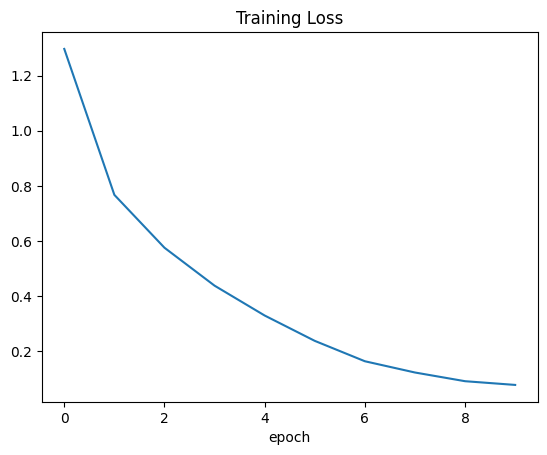

In [ ]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
PATH = './cifar_resnet.pth' # 모델 저장 경로
torch.save(resnet.state_dict(), PATH) # 모델 저장

In [ ]:
resnet = modeltype('resnet18').to(device)
resnet.load_state_dict(torch.load(PATH)) # 모델 파라메타 불러오기

<All keys matched successfully>

In [ ]:
# 평가 데이터를 이용해 정확도를 구해보자.
# output은 미니배치의 결과가 산출되기 때문에 for문을 통해서 test 전체의 예측값을 구한다.

correct = 0
total = 0
with torch.no_grad():
    resnet.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # 개수 누적(총 개수)
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)

print('Test accuracy: %.2f %%' % (100 * correct / total))

# AlexNet: Test accuracy: 76.44 %
# ResNet: Test accuracy: 84.35 %

Test accuracy: 84.35 %


In [ ]:
class bottleneck_residual_block(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.stride = stride
        self.expansion = 4
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv_block = nn.Sequential(
            # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride,
                      padding=0, bias=False),
            nn.BatchNorm2d(self.out_channels), # 배치 정규화: 각 배치의 평균과 분산을 이용해 데이터를 정규화하는 방법
            nn.ReLU(),
            # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1,
                      padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),

            nn.Conv2d(self.out_channels, self.out_channels * self.expansion, kernel_size=1, stride=1,
                      padding=0, bias=False),
            nn.BatchNorm2d(self.out_channels * self.expansion),
            )

        # stride가 1이 아니라면, Identity mapping이 아닌 경우
        '''ResNet는 ResidualBlock을 하나 거칠때 마다 이미지 사이즈가 줄어들고,
           채널 수는 늘어나는 구조. 따라서 처음 들어오는 x값과 블록을 거친 out값은 크기가 같아야 한다.
           따라서 차이가 나는 경우 풀력값의 크기와 입력값의 크기를 동일하게 하기 위해 별도의 컨볼루션
           연산을 진행하여 크기를 맞춰준다.'''
        if self.stride != 1 or self.in_channels != (self.out_channels * self.expansion):
            self.downsample = nn.Sequential(
                            nn.Conv2d(self.in_channels, self.out_channels * self.expansion,
                                      kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(self.out_channels * self.expansion))

    def forward(self, x):
        out = self.conv_block(x)
        if self.stride != 1 or self.in_channels != (self.out_channels * self.expansion):
            x = self.downsample(x)

        out = F.relu(x + out) # Skip Connection 수행
        return out

In [ ]:
class ResNet50(nn.Module):
    def __init__(self, num_blocks = [3,4,6,3], num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.base = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False),
                        nn.BatchNorm2d(64),
                        nn.ReLU()) # 이미지가 입력되어 수행하는 초기층을 생성
        # _make_layer를 이용해 ResidualBlock 4개를 만든다.
        # num_blocks[0]은 2개의 컨볼루션 연산 묶음을 몇개 생성할건지 설정
        # stride값을 2로 주어 이미지의 너비와 높이를 줄인다.
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        self.avgp2d = nn.AvgPool2d(4) # 4: 필터 사이즈
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):

        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            block = bottleneck_residual_block(self.in_channels, out_channels, stride)
            layers.append(block)
            self.in_channels = out_channels * 4

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgp2d(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
# 구글 이미지 크롤링
# pip install selenium==3.0.0

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup as bs
import urllib.request
from tqdm.notebook import tqdm
import os
import time


driver = webdriver.Chrome('c:/sample_data/chromedriver.exe')
driver.get('https://www.google.com')
time.sleep(0.5)
keyword = input('이미지 검색어 입력: ')

q = driver.find_element_by_css_selector('#APjFqb')
q.click()
q.send_keys(keyword)
q.submit()
time.sleep(0.5)

driver.find_element_by_css_selector('#bqHHPb > div > div > a:nth-child(1)').click()
time.sleep(0.5)

body = driver.find_element_by_css_selector('body')

for i in range(30):
    body.send_keys(Keys.PAGE_DOWN)
    time.sleep(1)

driver.find_element_by_css_selector('#islmp > div > div > div > div > div.C5Hr4 > div.K414Oe > div.FAGjZe > input').click()

for i in range(10):
    body.send_keys(Keys.PAGE_DOWN)
    time.sleep(0.5)

html_source = driver.page_source
soup = bs(html_source, "html.parser")

isvr_lst = soup.find('div', class_='mJxzWe').find_all('div',class_='isv-r')
img_lst=[]
for img_url in isvr_lst:
    try:
        img_lst.append(img_url.find('img')['src'])
    except:
        img_lst.append(img_url.find('img')['data-src'])

# 저장폴더 생성
fDir="c:/sample_data/"
fName=os.listdir(fDir)    # fdir에 있는 파일 리스트 반환

### 저장할 폴더 존재여부 확인
cnt = 0
fName_dir=keyword + str(cnt)

while True:
    if fName_dir not in fName:        # 새로 생성한 폴더가 현재 저장 위치에 있다/없다 결정
        os.makedirs(fDir + fName_dir)   # 없으면 현재 이름으로 폴더 생성
        break                         # 폴더 생성 후 while 문 빠져나가기
    cnt+=1
    fName_dir = keyword + str(cnt)        # 새로운 폴더명 생성
print(fDir + fName_dir,"로 폴더 생성")

cnt = 0
for img in tqdm(img_lst,desc = '저장중..'):
    tmp_name = fDir + fName_dir +'/' + keyword + str(cnt) + '.jpg'
    urllib.request.urlretrieve(img, tmp_name)
    cnt += 1

driver.close()